In [1]:
import os
os.chdir("..")  # Moves one directory up

In [2]:
import importlib
importlib.import_module("models")

<module 'models' from 'c:\\Users\\user\\Documents\\Ariel\\pycharm_projects\\Drug_Response_Analysis\\src\\models\\__init__.py'>

In [3]:
import pandas as pd 
import numpy as np 
from utils.config import base_path
from preprocessing.preprocess import concat_metadata_with_gene_expression,prepare_dataset_for_feature_selection,normalize_features
from preprocessing.feature_selection import getting_best_features
from sklearn.model_selection import train_test_split
from models.model_traning import train_xgboost_classifier

In [4]:
gene_expression = pd.read_csv(base_path/ "gene_expression.csv")
meta_data = pd.read_csv(base_path/ "meta_data.csv")

df = concat_metadata_with_gene_expression(meta_data,gene_expression,filter_nan_target=True)
df.head()

,SampleID,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,Tissue,disease state,protocol,disease activity score (das28),Response status,Gender
0,GSM381194,2.377898,7.109049,9.630326,2.331110,2.326892,7.145603,3.134364,2.374527,9.394731,...,2.389734,2.391520,2.372542,2.383567,whole blood,rheumatoid arthritis,anti_TNF therapy,4.51,Responder,Male
1,GSM381195,2.378662,5.156438,8.871972,2.337406,2.325880,6.724430,3.132534,2.371931,8.343010,...,2.389150,2.388430,2.371702,2.383306,whole blood,rheumatoid arthritis,anti_TNF therapy,6.04,Non_responder,Female
2,GSM381196,2.382631,5.321988,8.348816,2.334704,2.326533,6.856559,2.996339,2.373904,8.742820,...,2.389496,2.390634,2.373524,2.384077,whole blood,rheumatoid arthritis,anti_TNF therapy,5.92,Non_responder,Male
4,GSM381198,2.461926,5.980662,8.807910,2.334267,2.327032,7.758407,3.444969,2.375944,9.125310,...,2.389583,2.392193,2.373700,2.384135,whole blood,rheumatoid arthritis,anti_TNF therapy,6.00,Non_responder,Female
5,GSM381199,3.290609,6.352822,9.133817,2.337572,2.328993,7.381657,3.148597,2.399196,9.176213,...,2.397028,2.400408,2.378989,2.390307,whole blood,rheumatoid arthritis,anti_TNF therapy,5.20,Responder,Female


In [5]:
print(df["Response status"].unique())

['Responder' 'Non_responder']


In [6]:
X,y = prepare_dataset_for_feature_selection(df)
# X

In [7]:
# Step 1: Split into 80% Train, 20% (Val + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2: Split the remaining 20% into 10% Validation, 10% Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

# # Step 3: Normalize features
# X_train_scaled = normalize_features(X_train.value)
# X_val_scaled = normalize_features(X_val.value)


selected_features= list(getting_best_features(X_train,y_train))

In [8]:
selected_features

['236203_at',
 '1559434_at',
 '225840_at',
 '216883_x_at',
 '238141_s_at',
 '241400_at',
 '225437_s_at',
 '208613_s_at',
 '232477_at',
 '214318_s_at']

In [9]:
selected_features = selected_features + ["disease activity score (das28)", "Gender"]
selected_features

['236203_at',
 '1559434_at',
 '225840_at',
 '216883_x_at',
 '238141_s_at',
 '241400_at',
 '225437_s_at',
 '208613_s_at',
 '232477_at',
 '214318_s_at',
 'disease activity score (das28)',
 'Gender']

In [10]:
# X[selected_features].info()

In [11]:
X_train,X_val= X_train[selected_features],X_val[selected_features]

In [12]:
X_train_scaled = normalize_features(X_train)
X_val_scaled = normalize_features(X_val)

In [13]:
X_train_scaled

,236203_at,1559434_at,225840_at,216883_x_at,238141_s_at,241400_at,225437_s_at,208613_s_at,232477_at,214318_s_at,disease activity score (das28),Gender
1,0.318251,-0.283496,-0.734622,-1.568328,-0.681132,-0.462303,-0.744795,0.179627,-0.139858,-0.718199,0.999590,0
58,-0.722847,-0.201272,0.184434,1.122826,0.924845,-0.456806,2.352576,-0.369889,-0.324311,0.718659,-1.484143,1
74,-0.314667,-0.082176,1.256572,-0.327941,2.925601,-0.758001,1.254789,-0.598514,-0.319849,2.833098,-0.294261,1
49,1.481247,-0.026884,-1.227633,0.795504,-0.673839,-0.455365,-0.732344,-0.587241,2.299513,-0.062204,-0.317366,0
65,-0.580675,-0.300253,0.462258,1.225826,-0.680540,-0.766207,-0.276265,-0.201537,0.205709,-0.786901,-0.837217,1
38,0.007077,-0.231609,-0.273710,0.175729,-0.274043,-0.376447,-0.739569,-0.599231,-0.361408,-0.647399,0.872516,0
63,-1.245416,-0.006923,2.913632,0.302981,-0.677064,-0.458479,0.264668,-0.603114,-0.427498,-0.632825,-0.386679,0
43,1.640476,-0.408069,-0.431709,-2.240798,-0.681876,-0.541045,-0.743435,-0.618677,-0.251964,-0.802967,-1.507248,1
56,-0.378669,-0.336591,1.878218,0.126346,-0.676806,-0.498066,-0.278196,-0.413407,0.072967,0.607639,1.195979,1
19,1.723976,-0.267638,-0.271638,0.173721,-0.678604,-0.176414,-0.738492,2.304667,3.202735,-0.335971,-2.835756,1


In [14]:
model = train_xgboost_classifier(X_train_scaled,y_train)

In [ ]:
from sklearn.metrics import classification_report

def evaluate_model(model,X_train_scaled,y_val_pred):

    y_train_pred = model.predict(X_train_scaled)

    y_val_pred = model.predict(X_val_scaled)

    # Predict on training and validation sets
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)

    # Generate classification reports
    train_report = classification_report(y_train, y_train_pred, target_names=["Non-Responder", "Responder"])
    val_report = classification_report(y_val, y_val_pred, target_names=["Non-Responder", "Responder"])

    # Print Reports
    print("Classification Report - Training Data:\n", train_report)
    print("\nClassification Report - Validation Data:\n", val_report)

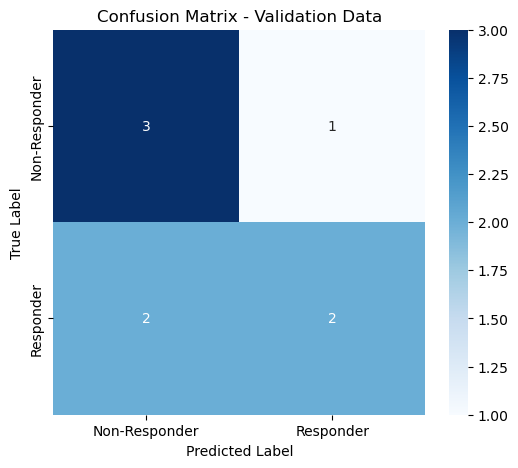

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_val, y_val_pred):
    # Create confusion matrix
    conf_matrix = confusion_matrix(y_val, y_val_pred)

    # Define labels
    labels = ["Non-Responder", "Responder"]

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Validation Data")
    plt.show()


In [21]:
# Get feature importance values
feature_importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Display top features
print(feature_importance_df.head(12).sort_values)  # Show top 10 most important features


<bound method DataFrame.sort_values of                            Feature  Importance
9                      214318_s_at    0.327395
6                      225437_s_at    0.151903
0                        236203_at    0.131694
2                        225840_at    0.102461
4                      238141_s_at    0.076595
3                      216883_x_at    0.075527
5                        241400_at    0.065540
8                        232477_at    0.035596
7                      208613_s_at    0.033290
1                       1559434_at    0.000000
10  disease activity score (das28)    0.000000
11                          Gender    0.000000>


C:\Users\user\AppData\Local\Temp\ipykernel_28592\1632563385.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df["Importance"][:10], y=feature_importance_df["Feature"][:10], palette="viridis")


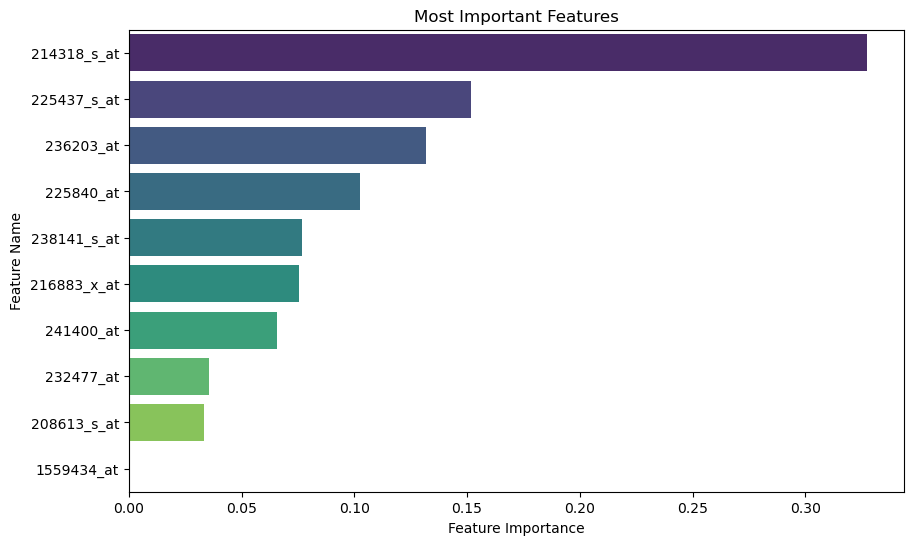

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df["Importance"][:10], y=feature_importance_df["Feature"][:10], palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Most Important Features")
plt.show()
